In [101]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from PIL import Image

In [104]:
import pandas as pd
data = pd.read_csv('D:/DatasetDoAnCoSO/excel_emotion/fer2013.csv')
data.head(20)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


<Figure size 1400x800 with 0 Axes>

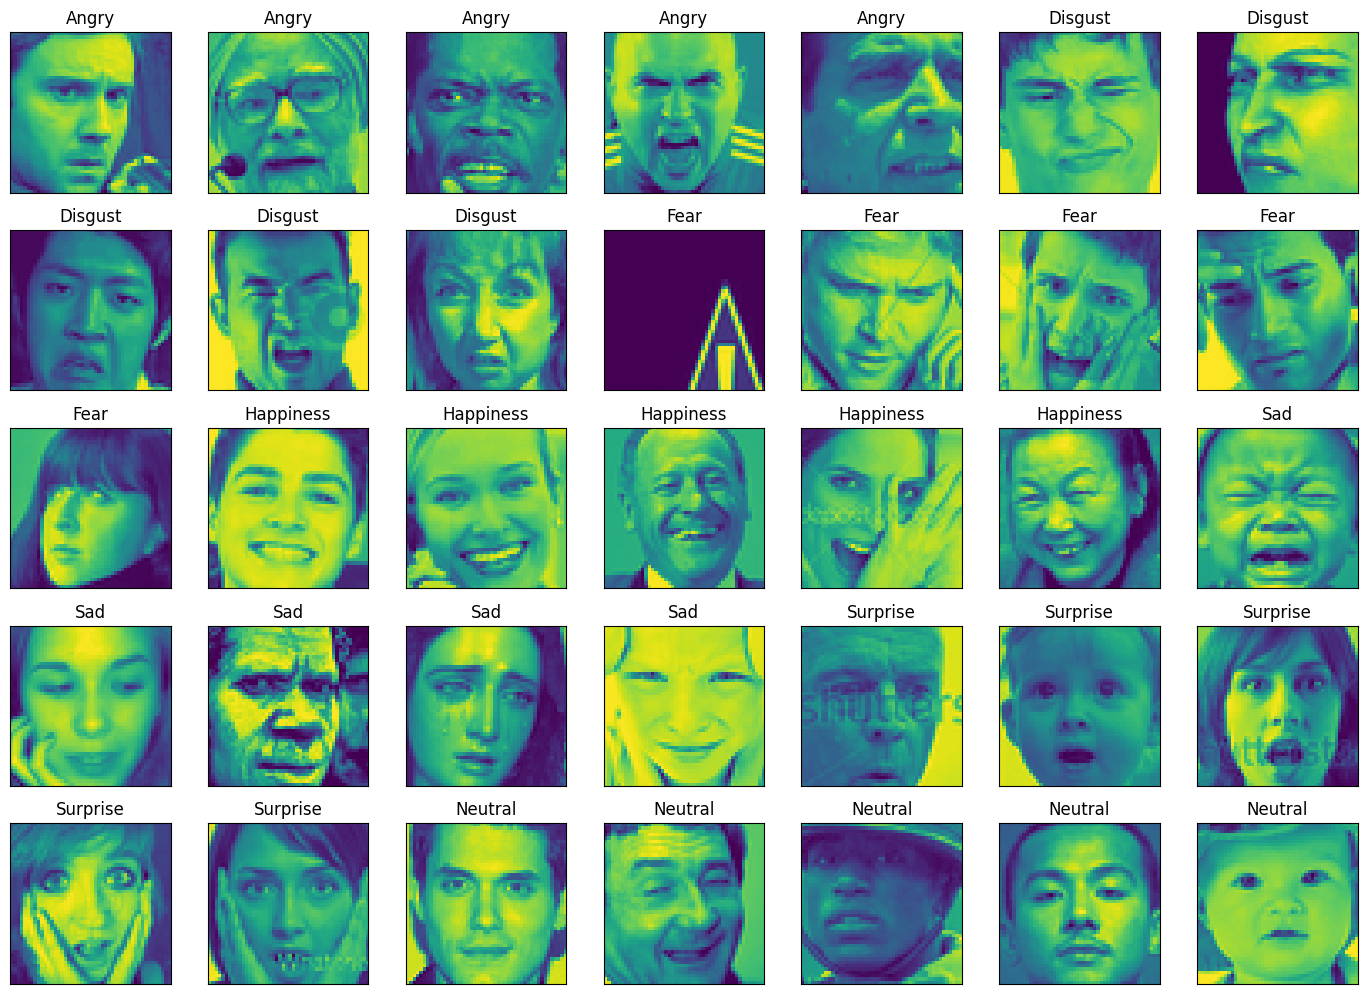

<Figure size 1400x800 with 0 Axes>

In [105]:
label_to_text = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
label_to_text

fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))

In [107]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
x_data = data['pixels']
y_data = data['emotion']

In [108]:
# Thực hiện lấy mẫu ngẫu nhiên cho tập huấn luyện
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)


y_data.value_counts()

(62923, 1)   (62923,)


emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64

In [109]:
# Chuyển đổi dữ liệu thành 1 chiều
x_data = pd.Series(x_data.flatten())
x_data

# Chuyển đổi dữ liệu thành mảng numpy
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

# Chuyển đổi dữ liệu thành định dạng hình ảnh 48x48
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)
     
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 1), (6293, 1))

In [110]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 7)
y_train.shape
y_test = to_categorical(y_test, 7)
y_test.shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.25),
    
     Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,975 (4.26 MB)

 Trainable params: 1,114,695 (4.25 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [112]:
# Compile mô hình
from tensorflow import keras
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# Train mô hình
history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test))

print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

model.save('emotion_model.keras')

Epoch 1/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 956s 538ms/step - accuracy: 0.2306 - loss: 1.8754 - val_accuracy: 0.4262 - val_loss: 1.4948
Epoch 2/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 588s 332ms/step - accuracy: 0.4293 - loss: 1.4826 - val_accuracy: 0.5130 - val_loss: 1.2669
Epoch 3/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 839s 474ms/step - accuracy: 0.5057 - loss: 1.2854 - val_accuracy: 0.5684 - val_loss: 1.1205
Epoch 4/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 869s 491ms/step - accuracy: 0.5557 - loss: 1.1622 - val_accuracy: 0.6016 - val_loss: 1.0417
Epoch 5/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 900s 508ms/step - accuracy: 0.5908 - loss: 1.0597 - val_accuracy: 0.6259 - val_loss: 0.9706
Epoch 6/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 914s 503ms/step - accuracy: 0.6160 - loss: 0.9918 - val_accuracy: 0.6488 - val_loss: 0.9147
Epoch 7/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 920s 520ms/step - accuracy: 0.6442 - loss: 0.9358 - val_accuracy: 0.6593 - val_loss: 0.8923
Epoch 8/50
1770/1770 ━━━━━━━━━━━━━━━━━━━━ 922s 521ms/step - ac